- Referências:
    - [Documentação do Edge Impulse Studio - _Spectral features processing blocks_](https://docs.edgeimpulse.com/docs/edge-impulse-studio/processing-blocks/spectral-features)
    - [Repositório do Edge Impulse Studio - _Edge Impulse processing blocks_](https://github.com/edgeimpulse/processing-blocks)
    - [TinyML - Machine Learning for Embedding Devices](https://github.com/Mjrovai/UNIFEI-IESTI01-TinyML) de [Marcelo José Rovai](http://lattes.cnpq.br/4234592863079468) do [Instituto de Engenharia de Sistemas e Tecnologias da Informação – IESTI - Campus de Itajubá](https://unifei.edu.br/iesti/)

# Edge Impulse - Bloco de análise espectral
[![Abra no Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fabiobento/continuous-motion-recognition/blob/main/Edge_Impulse_Spectral_Analysis_Block.ipynb)

## FFT
### Características estatísticas(domínio do tempo) por eixo/canal:
Após a filtragem por meio de um filtro Butterworth IIR (se ativado), **a média é subtraída do sinal.** e são calculados:
- RMS
- Assimetria(_skewness_)
- Curtose(_kurtosis_)

### Características espectrais (domínio de frequência) por eixo/canal:
- Potência espectral
- Assimetria
- Curtose

### Potência espectral
O sinal filtrado é passado para a seção de potência espectral(_spectral power_), que calcula a **FFT** para calcular as características espectrais.
- A janela será dividida em quadros (ou “subjanelas”), e a FFT é calculada a partir de cada quadro.
- O comprimento da FFT determina o número de compartimentos(_bins_) da FFT, bem como a resolução dos picos de frequência que você pode separar. 
- O número total de recursos de potência espectral será alterado, dependendo de como você definir os parâmetros de filtro e FFT. Sem filtragem, o número de recursos é 1/2 do comprimento da FFT 

https://docs.edgeimpulse.com/docs/edge-impulse-studio/processing-blocks/spectral-features

## Wavelets
No caso das **Wavelets**, os recursos extraídos são recursos estatísticos, recursos de cruzamento e recursos de entropia (14 por camada): 

- `[11] Recursos`: são calculados **n5, n25, n75, n95, média, mediana, desvio padrão (std), variância (var) e raiz quadrada média (rms), curtose e assimetria (skew)**. 

- `[2] Recursos`: **Taxa de cruzamento zero (zcross) e taxa de cruzamento médio (mcross)** são as vezes em que o sinal passa pela linha de base y = 0 e pelo nível médio y = u por unidade de tempo, respectivamente

- `[1] Recurso`: Os recursos de **Entropia** são uma medida característica da complexidade do sinal

- Todos os 14 valores são calculados para cada camada (incluindo L0, o sinal original)

- `[Inputs]`: O **nível de decomposição de wavelet** (*1, 2, ...*) e o tipo de **Wavelet** (*bior1.3, db2, ...*) a ser usado devem ser definidos. Se, por exemplo, o nível 1 for escolhido, L0 e L1 serão usados para o cálculo do recurso.

- O número total de recursos mudará, dependendo de como você definir o filtro e o número de camadas. Por exemplo, com a filtragem **[None]** e o nível **[1]**, o número de recursos por eixo será 14 x 2 (L0 e L1) = 28. Para 6 eixos, teremos um total de 168 recursos. 

## Características Estatísticas

In [86]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import math
from scipy.stats import skew, kurtosis
from scipy import signal
from scipy.signal import welch
from scipy.stats import entropy
from sklearn import preprocessing
import pywt

In [87]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['lines.linewidth'] = 3

## Funções

In [88]:
def plot_data(sensors, axis, title):
    [plt.plot(x, label=y) for x,y in zip(sensors, axis)]
    plt.legend(loc='lower right')
    plt.title(title)
    plt.xlabel('#Amostra')
    plt.ylabel('Valor')
    plt.box(False)
    plt.grid()
    plt.show()

Vamos obter uma amostra de dados de acelerômetros (janela de 2 segundos; frequência de amostragem de 62,5 Hz)

<figure>
    <center> <img src="https://github.com/fabiobento/continuous-motion-recognition/raw/main/images/features.png"  alt='missing' width="800"  ><center/>
<figure/>

In [89]:
f =  62.5  # Hertz
wind_sec = 2 # seconds
axis = ['accX', 'accY', 'accZ']
n_sensors = len(axis)
print (f'Frequência = {f}Hz')
print (f'Janela = {wind_sec}s')
print (f'Quantidade de sensores = {len(axis)}')

Frequência = 62.5Hz
Janela = 2s
Quantidade de sensores = 3


In [90]:
data=[-5.6330, 0.2376, 9.8701, -5.9442, 0.4830, 9.8701, -5.4217, 0.9433, 9.8521, -4.1474, 0.5261, 9.8246, -0.4896, -0.2592, 9.7217, -1.9465, 0.1472, 9.9108, -4.8261, 0.0449, 9.8964, -5.8861, 0.6291, 9.8988, -3.6248, 0.6734, 9.8731, -3.2585, 0.5866, 9.8491, -3.2304, 0.3358, 9.9000, -2.4187, -0.1071, 9.8593, -1.6017, -0.5381, 9.7941, -2.2577, -0.1760, 9.7803, -1.2438, -0.2873, 9.8438, -0.9978, 0.4076, 9.6696, -1.3210, -1.6514, 9.9754, -2.3337, -0.6740, 9.8084, -2.1272, -0.7195, 9.8330, -0.9792, -0.5584, 9.8013, 0.4615, 0.3041, 9.8306, 0.4076, 0.1861, 9.8390, -0.2682, -0.3226, 9.8043, 1.8477, 0.0377, 9.7977, 0.7560, -0.3166, 9.8072, 0.4764, -0.2215, 9.9084, 1.5724, -0.2274, 9.6744, 3.5195, -1.0169, 9.8234, 5.0560, -0.7021, 9.8270, 1.5137, -2.2853, 9.7875, 2.4044, 0.3328, 9.7582, 6.3111, -1.8765, 9.8288, 1.7196, -0.7302, 9.8623, 2.9999, -0.3268, 9.6516, 2.0800, -1.0092, 10.0347, 0.2867, -0.2406, 9.9653, 4.7908, -2.2739, 9.5343, -0.2652, 2.5833, 11.1749, 5.4857, -1.2103, 9.5672, 3.6763, -2.2194, 9.7282, 2.3888, -1.7867, 9.8276, 2.8802, -1.1588, 9.8970, 2.3320, -1.4042, 9.7977, 2.0650, -0.6913, 9.8228, 2.4505, -0.6297, 9.8025, 1.2851, -0.4441, 9.8354, 1.5113, -0.2927, 9.8282, 1.5616, 0.2173, 9.8090, 1.0199, 0.9936, 9.9192, 1.0570, 0.2257, 9.9317, 0.5112, 0.0192, 9.8336, -0.2867, -0.6770, 9.8180, -0.2017, -1.1558, 9.8192, -0.3322, -0.9535, 9.7665, -0.9379, -0.4998, 9.7588, -1.2540, -0.3106, 9.8240, -1.5287, 0.0634, 9.9108, -2.6606, 0.5758, 9.8779, -3.2723, 0.6482, 9.8761, -4.0121, 0.3585, 9.8462, -4.4945, 1.2276, 9.9042, -4.5849, 1.7909, 9.9000, -4.4335, 1.6777, 9.9060, -5.1697, 1.1486, 9.9377, -3.9115, 0.7159, 9.8857, -1.8699, -0.5561, 9.8845, -1.1618, 0.1490, 9.8497, -3.2902, 0.6542, 9.8683, -5.5055, 0.7530, 9.8845, -5.1739, 0.7482, 9.8821, -3.6524, 0.5028, 9.8641, -3.2645, 0.1778, 9.8629, -3.2423, -0.0048, 9.8970, -1.6729, 0.0311, 9.8013, -0.3244, -0.3364, 9.7839, -0.9966, -0.6692, 9.8761, -1.9950, -0.2113, 9.8964, -2.0075, 0.3011, 9.7965, -1.8633, 0.3370, 9.9288, -0.8739, 0.5926, 9.8162, -0.4046, 0.3974, 9.8665, 0.4830, -0.6788, 9.8659, 0.6201, -0.8948, 9.8312, 0.8027, -0.8200, 9.7725, 0.5213, -0.6087, 9.8126, 0.0275, -0.5608, 9.7713, 0.2412, -0.1885, 9.8665, 0.7596, -0.0581, 9.8521, 0.6907, -0.5483, 9.8881, 0.3244, -0.9978, 9.7773, 1.0576, -0.6584, 9.7887, 2.0722, -0.2753, 9.8120, 1.4647, -0.2221, 9.8928, 1.4617, 0.1341, 9.8120, 2.2188, -0.0329, 9.7773, 3.6859, -0.5171, 9.9084, 1.9172, -0.9744, 9.8019, 1.7095, -0.6734, 9.8061, 3.4327, -1.1205, 9.8372, 3.4399, -0.9679, 9.8342, 2.4307, -1.3473, 9.8240, 1.1283, -0.1945, 9.9479, 6.9707, -0.0946, 9.6744, 3.0957, -1.3120, 9.8617, 3.1448, -1.0924, 9.7701, 2.9862, -1.1349, 9.8144, 2.6073, -0.7344, 9.8025, 2.0824, -0.6955, 9.8396, 1.9932, -0.6812, 9.7809, 1.6640, -0.3089, 9.8845, 2.6833, -0.2879, 9.7929, 2.3272, -0.1706, 9.8288, 1.3761, -0.3537, 9.9228, 0.9643, -1.0145, 9.8318, 1.3420, -1.1498, 9.8360, 0.9942, -0.7326, 9.8288, 0.1395, -0.3202, 9.8695, -0.2993, -0.3220, 9.8527, -0.6967, -0.3980, 9.8360, -1.4706, -0.1879, 9.8342, -1.9974, 0.5267, 9.8474, -2.1883, 0.5584, 9.8695, -2.3409, 0.4447, 9.8815, -3.1214, 0.1730, 9.9168, -3.1502, -0.0156, 9.9174]
No_raw_features = len(data)
N = int(No_raw_features/n_sensors)
print (f"Quantidade de características brutas: {No_raw_features};\nN= {N} (quantidade de características por eixo)")

Quantidade de características brutas: 375;
N= 125 (quantidade de características por eixo)


In [92]:
# Características Processadas
features = [2.7322, -0.0978, -0.3813, 2.3980, 3.8924, 24.6841, 9.6303, 8.4867, 7.7793, 2.9963, 5.6242, 3.4198, 4.2735, 0.7833, 0.1735, 1.1696, 0.9426, -0.8039, 5.4290, 0.9990, 1.0315, 0.9459, 1.8117, 0.9088, 1.3302, 3.1120, 0.1383, 6.8629, 65.3726, 0.3117, -1.3812, 0.0606, 0.0570, 0.0567, 0.0976, 0.1940, 0.2574, 0.2083, 0.1660]
N_feat = len(features)
N_feat_axis = int(N_feat/n_sensors)

In [93]:
print(f' - Número total de recursos sem filtragem: {N_feat}')
print(f' - Número total de recursos estatísticos : {3*n_sensors}')
print(f' - Número total de recursos espectrais : {N_feat-3*n_sensors}')
print(f' - Total Número de recursos por eixo: {N_feat_axis}')

 - Número total de recursos sem filtragem: 39
 - Número total de recursos estatísticos : 9
 - Número total de recursos espectrais : 30
 - Total Número de recursos por eixo: 13


- 3 Recursos estatísticos (tempo) por eixo --> Total: 9 recursos 
- 8 Recursos de potência espectral (Freq) por eixo --> Total: 24 recursos
- 2 Skew/Kurtosis espectral (freq) por eixo -> Total: 6 recursos
- Total de recursos processados = 9+24+6 = 39

Recursos por eixo: `[rms] [skew] [kurtosis] [spectral skew] [spectral kurtosis] [Spectral Power 1] ... [Spectral Power 8]`

### Dividir dados brutos (_raw data_) por sensor

In [94]:
accX = data[0::3]
accY = data[1::3]
accZ = data[2::3]
sensors = [accX, accY, accZ]

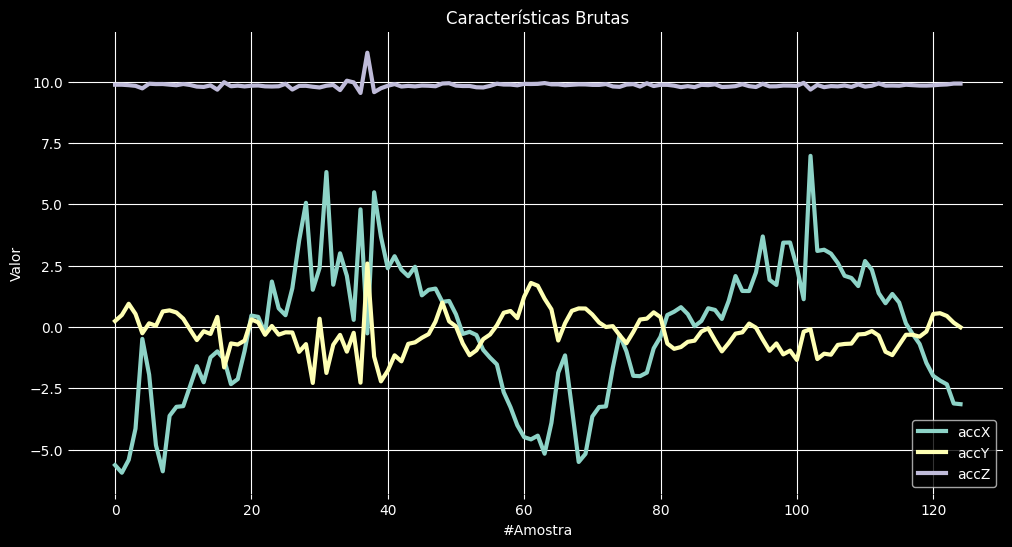

In [34]:

plot_data(sensors, axis, 'Características Brutas')

### Subtraindo a média dos dados
Subtrair a média de um conjunto de dados é uma etapa comum de pré-processamento de dados em estatística e aprendizado de máquina. O objetivo de subtrair a média dos dados é centralizar os dados em torno de zero. Isso é importante porque pode revelar padrões e relacionamentos que podem estar ocultos se os dados não estiverem centralizados.

Aqui estão alguns motivos específicos pelos quais a subtração da média pode ser útil:

- Simplifica a análise: Ao centralizar os dados, a média se torna zero, o que pode tornar alguns cálculos mais simples e fáceis de interpretar.
- Remove a tendência: se os dados tiverem uma tendência, a subtração da média pode remover essa tendência e permitir uma análise mais precisa.
- Pode revelar padrões: A centralização dos dados pode ajudar a revelar padrões que podem estar ocultos se os dados não estiverem centralizados. Por exemplo, se estiver analisando um conjunto de dados de série temporal, a centralização dos dados pode ajudá-lo a identificar tendências ao longo do tempo.
- Pode melhorar o desempenho: Em alguns algoritmos de aprendizado de máquina, a centralização dos dados pode melhorar o desempenho, reduzindo a influência de outliers e tornando os dados mais facilmente comparáveis.
De modo geral, a subtração da média é uma técnica simples, mas poderosa, que pode ser usada para melhorar a análise e a interpretação dos dados.

In [95]:
dtmean = [(sum(x)/len(x)) for x in sensors]
[print(x+' médio'+'= ', round(y, 4)) for x,y in zip(axis, dtmean)][0]

accX médio=  -0.1646
accY médio=  -0.2438
accZ médio=  9.8472


In [36]:
accX = [(x - dtmean[0]) for x in accX]
accY = [(x - dtmean[1]) for x in accY]
accZ = [(x - dtmean[2]) for x in accZ]
sensors = [accX, accY, accZ]

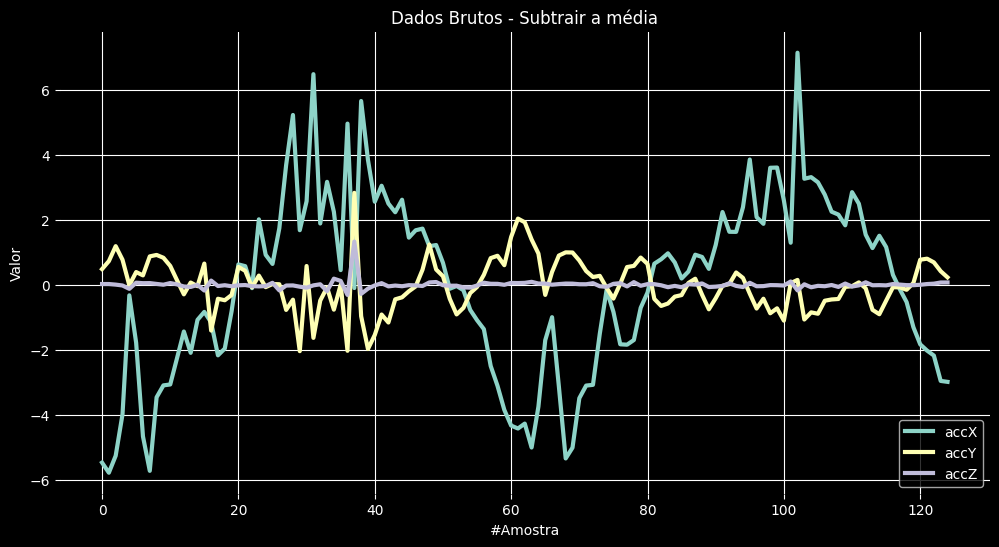

In [37]:
plot_data(sensors, axis, 'Dados Brutos - Subtrair a média')

### Cálculo do valor RMS

O valor RMS de um conjunto de valores (ou uma forma de onda de tempo contínuo) é a raiz quadrada da média aritmética dos quadrados dos valores ou o quadrado da função que define a forma de onda contínua.

Na física, o valor de corrente RMS também pode ser definido como o “valor da corrente direta que dissipa a mesma potência em um resistor”.

No caso de um conjunto de $n$ valores $\{x_{1},x_{2},\dots ,x_{n}\}$, o RMS é:

$\displaystyle x_{\text{RMS}}={\sqrt {{\frac {1}{n}}\left(x_{1}^{2}+x_{2}^{2}+\cdots +x_{n}^{2}\right)}}.$

`OBSERVE que o valor RMS é diferente para os dados brutos originais e após a subtração da média`

In [38]:
# Usando dados numéricos e padronizados (subtraindo a média)
rms = [np.sqrt(np.mean(np.square(x))) for x in sensors]
[print('rms_'+x+'= ', round(y, 4)) for x,y in zip(axis, rms)][0]

rms_accX=  2.7322
rms_accY=  0.7833
rms_accZ=  0.1383


In [39]:
# # Compare com os recursos de resultados do Edge Impulse
print(features[0:N_feat:N_feat_axis])

[2.7322, 0.7833, 0.1383]


### Cálculo da assimetria(_skewness_) e da curtose(_kurtosis_)

Em estatística, a assimetria e a curtose são duas maneiras de medir a **forma de uma distribuição**.

[**Skewness**](https://en.wikipedia.org/wiki/Skewness) é uma medida da assimetria de uma distribuição. Esse valor pode ser positivo ou negativo.
<figure>
    <center> <img src="https://github.com/fabiobento/continuous-motion-recognition/raw/main/images/skewness.png"  alt='missing' width="400"  ><center/>
<figure/>

- Uma inclinação negativa indica que a cauda está no lado esquerdo da distribuição, que se estende para valores mais negativos.
- Uma inclinação positiva indica que a cauda está no lado direito da distribuição, que se estende em direção a valores mais positivos.
- Um valor de zero indica que não há assimetria na distribuição, o que significa que a distribuição é perfeitamente simétrica.


[**Kurtosis**](https://en.wikipedia.org/wiki/Kurtosis) é uma medida que indica se uma distribuição tem ou não cauda pesada ou cauda leve (_heavy-tailed or light-tailed_) em relação a uma distribuição normal.

<figure>
    <center> <img src="https://github.com/fabiobento/continuous-motion-recognition/raw/main/images/kurtosis.png"  alt='missing' width="400"  ><center/>
<figure/>

- A curtose de uma distribuição normal é 0.
- Se uma determinada distribuição tiver uma curtose negativa, diz-se que ela é [platicúrtica](https://pt.wikipedia.org/wiki/Platic%C3%BArtica), o que significa que ela tende a produzir menos outliers e menos extremos do que a distribuição normal.
- Se uma determinada distribuição tiver uma curtose positiva, ela será considerada [leptocúrtica](https://pt.wikipedia.org/wiki/Curtose), o que significa que tende a produzir mais outliers do que a distribuição normal.

OBSERVE que os valores de Skewness e Kurtosis são os mesmos para os dados brutos originais e após a subtração da média.

Vejamos a distribuição de dados e o cálculo de assimatria e curtose

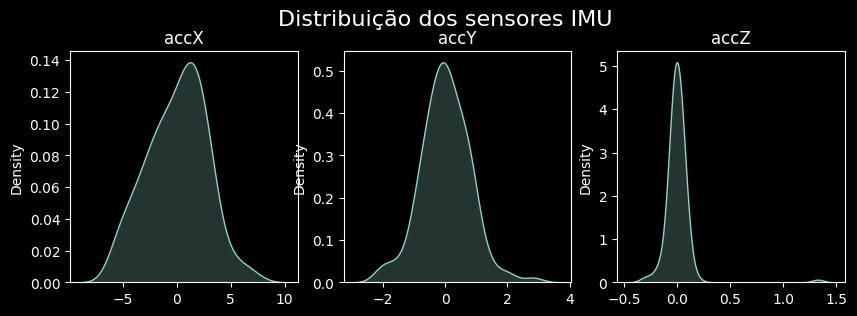

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
sns.kdeplot(accX, fill=True, ax=axes[0])
sns.kdeplot(accY, fill=True, ax=axes[1])
sns.kdeplot(accZ, fill=True, ax=axes[2])
axes[0].set_title('accX')
axes[1].set_title('accY')
axes[2].set_title('accZ')
plt.suptitle('Distribuição dos sensores IMU', fontsize=16, y=1.02)
plt.show()

In [41]:
skew_list = [skew(x, bias=False) for x in sensors]
[print('assimetria de '+x+'= ', round(y, 4)) for x,y in zip(axis, skew_list)][0]

assimetria de accX=  -0.099
assimetria de accY=  0.1756
assimetria de accZ=  6.9463


In [42]:
# Compare com os resultados do Edge Impulse para as características
features[1:N_feat:N_feat_axis]

[-0.0978, 0.1735, 6.8629]

In [43]:
kurt = [kurtosis(x, bias=False) for x in sensors]
[print('Curtose de '+x+'= ', round(y, 4)) for x,y in zip(axis, kurt)][0]

Curtose de accX=  -0.3475
Curtose de accY=  1.2673
Curtose de accZ=  68.1123


In [44]:
# Compare com os resultados do Edge Impulse para as características
features[2:N_feat:N_feat_axis]

[-0.3813, 1.1696, 65.3726]

## Características Espectrais

In [45]:
FFT_Lenght = 16 
fs = f 
print (f"Frequência de amostragem: {f}Hz")

Frequência de amostragem: 62.5Hz


A janela amostrada geralmente é maior que o tamanho da FFT, então a janela será dividida em quadros (ou “subjanelas”), e a FFT será calculada a partir de cada quadro.

**Comprimento da FFT** - O tamanho da FFT. Isso determina o número de compartimentos da FFT, bem como a resolução dos picos de frequência que você pode separar. Um número menor significa que mais sinais ficarão em média juntos no mesmo compartimento de FFT, mas também reduz o número de recursos e o tamanho do modelo. Um número maior separará mais sinais em compartimentos separados, mas gerará um modelo maior.

### Potência Spectral Power - Método de Welch’s
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html

Para dividir o sinal no domínio da frequência em compartimentos e calcular o espectro de potência para cada compartimento, devemos usar um método chamado **Método de Welch**. 

Esse método divide o sinal em segmentos sobrepostos, aplica uma função de janela a cada segmento, calcula o periodograma de cada segmento usando DFT e calcula a média deles para obter uma estimativa mais suave do espectro de potência. 

In [46]:
# Função usada pelo Edge Impulse em vez de scipy.signal.welch().
def welch_max_hold(fx, sampling_freq, nfft, n_overlap):
    n_overlap = int(n_overlap)
    spec_powers = [0 for _ in range(nfft//2+1)]
    ix = 0
    while ix <= len(fx):
        # O fatiamento trunca se end_idx > len, e o rfft zera automaticamente o preenchimento
        fft_out = np.abs(np.fft.rfft(fx[ix:ix+nfft], nfft))
        spec_powers = np.maximum(spec_powers, fft_out**2/nfft)
        ix = ix + (nfft-n_overlap)
    return np.fft.rfftfreq(nfft, 1/sampling_freq), spec_powers

In [47]:
fax,Pax = welch_max_hold(accX, fs, FFT_Lenght, 0)
fay,Pay = welch_max_hold(accY, fs, FFT_Lenght, 0)
faz,Paz = welch_max_hold(accZ, fs, FFT_Lenght, 0)

In [48]:
specs = [Pax, Pay, Paz ]

Observe que, como subtraímos a média no início, o compartimento 0 (DC) sempre será ~0, portanto, nós o ignoramos (p[1:])

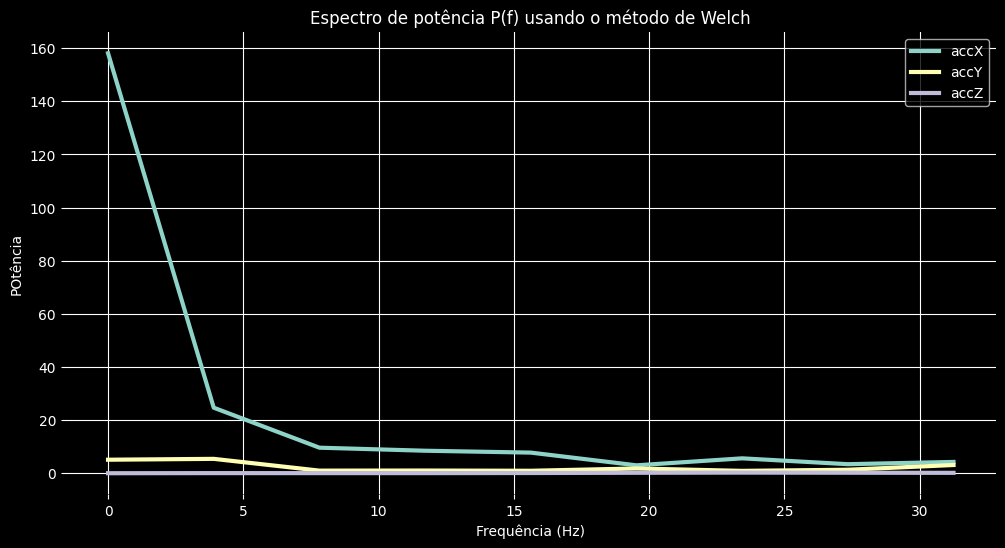

In [50]:
# Traçar o espectro de potência em relação à frequência 
# Como subtraímos a média no início, o compartimento 0 (DC) sempre será ~0, portanto, ignore-o
plt.plot(fax,Pax, label='accX')
plt.plot(fay,Pay, label='accY')
plt.plot(faz,Paz, label='accZ')

plt.legend(loc='upper right')
plt.xlabel('Frequência (Hz)')
#plt.ylabel('PSD [V**2/Hz]')
plt.ylabel('POtência')
plt.title('Espectro de potência P(f) usando o método de Welch')
plt.grid()
plt.box(False)
plt.show()

In [52]:
print("\nRecursos de potência espectral calculados para accX::")
[print(round(x, 4)) for x in Pax[1:]][0]


Recursos de potência espectral calculados para accX::
24.6844
9.6304
8.4865
7.7794
2.9964
5.6242
3.4198
4.2736


In [54]:
print("\nRecursos de potência espectral calculados para accY::")
[print(round(x, 4)) for x in Pay[1:]][0]


Recursos de potência espectral calculados para accY::
5.4289
0.999
1.0315
0.9458
1.8116
0.9088
1.3301
3.1121


In [51]:
print("\nRecursos de potência espectral calculados para accZ::")
[print(round(x, 4)) for x in Paz[1:]][0]


Recursos de potência espectral calculados para accZ::
0.0606
0.057
0.0567
0.0976
0.194
0.2574
0.2083
0.166


### Assimetria e Curtose espectrais

In [55]:
spec_skew = [skew(x, bias=False) for x in specs]
[print('spectral_skew_'+x+'= ', round(y, 4)) for x,y in zip(axis, spec_skew)][0]

spectral_skew_accX=  2.9069
spectral_skew_accY=  1.1426
spectral_skew_accZ=  0.3781


In [56]:
spec_kurtosis = [kurtosis(x, bias=False) for x in specs]
[print('spectral_kurtosis_'+x+'= ', round(y, 4)) for x,y in zip(axis, spec_kurtosis)][0]

spectral_kurtosis_accX=  8.5569
spectral_kurtosis_accY=  -0.3886
spectral_kurtosis_accZ=  -1.4874


### Liste os recursos espectrais por eixo e compare com o EI

In [59]:
print("Recursos espectrais processados pelo EI (accX): ")
print(features[3:N_feat_axis][0:])
print("\nRecursos Calculados:")
print (round(spec_skew[0],4))
print (round(spec_kurtosis[0],4))
[print(round(x, 4)) for x in Pax[1:]][0]

Recursos espectrais processados pelo EI (accX): 
[2.398, 3.8924, 24.6841, 9.6303, 8.4867, 7.7793, 2.9963, 5.6242, 3.4198, 4.2735]

Recursos Calculados:
2.9069
8.5569
24.6844
9.6304
8.4865
7.7794
2.9964
5.6242
3.4198
4.2736


In [60]:
print("Recursos espectrais processados pelo EI (accY): ")
print(features[16:26][0:]) #13: 3+N_feat_axis;  26 = 2x N_feat_axis
print("\nRecursos Calculados:")
print (round(spec_skew[1],4))
print (round(spec_kurtosis[1],4))
[print(round(x, 4)) for x in Pay[1:]][0]

Recursos espectrais processados pelo EI (accY): 
[0.9426, -0.8039, 5.429, 0.999, 1.0315, 0.9459, 1.8117, 0.9088, 1.3302, 3.112]

Recursos Calculados:
1.1426
-0.3886
5.4289
0.999
1.0315
0.9458
1.8116
0.9088
1.3301
3.1121


In [61]:
print("Recursos espectrais processados pelo EI (accZ): ")
print(features[29:][0:]) #29: 3+(2*N_feat_axis); 
print("\nRecursos Calculados:")
print (round(spec_skew[2],4))
print (round(spec_kurtosis[2],4))
[print(round(x, 4)) for x in Paz[1:]][0]

Recursos espectrais processados pelo EI (accZ): 
[0.3117, -1.3812, 0.0606, 0.057, 0.0567, 0.0976, 0.194, 0.2574, 0.2083, 0.166]

Recursos Calculados:
0.3781
-1.4874
0.0606
0.057
0.0567
0.0976
0.194
0.2574
0.2083
0.166


# Wavelets

<figure>
    <center> <img src="https://github.com/fabiobento/continuous-motion-recognition/raw/main/images/wavelets-features.png"  alt='missing' width="800"  ><center/>
<figure/>

In [62]:
wavelet_name='bior1.3'
num_layer = 1

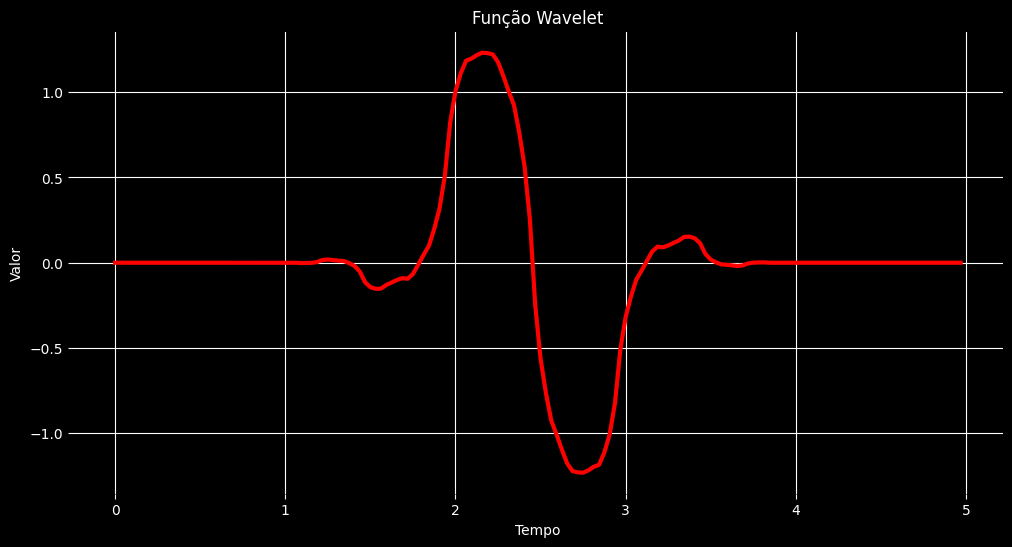

In [63]:
wavelet = pywt.Wavelet(wavelet_name)
[phi_d,psi_d,phi_r,psi_r,x] = wavelet.wavefun(level=5)
plt.plot(x, psi_d, color='red')
plt.title('Função Wavelet')
plt.ylabel('Valor')
plt.xlabel('Tempo')
plt.grid()
plt.box(False)
plt.show()

In [64]:
# Recursos Processados

features = [3.6251, 0.0615, 0.0615, -7.3517, -2.7641, 2.8462, 5.0924, 0.4063, -0.2133, 3.8473, 15.0327, 3.8532, -0.2905, -0.7966, 3.3929, 0.5231, 0.5538, -1.3234, -0.2743, 0.5206, 1.4599, 0.1350, 0.1264, 0.9544, 0.9250, 0.9627, 0.6358, 3.0473, 3.6597, 0.3077, 0.3077, -1.3234, -0.6492, 0.7844, 1.3610, 0.0659, 0.0276, 0.9345, 0.8868, 0.9349, 0.2807, -0.0589, 3.1609, 0.5385, 0.5385, -0.5356, -0.2709, 0.2298, 0.8409, -0.0830, -0.0377, 0.6040, 0.3706, 0.6052, -2.2028, 13.7548, 3.1061, 0.4000, 0.3692, -0.1126, -0.0494, 0.0347, 0.1022, -0.0137, 0.0025, 0.1053, 0.0113, 0.1053, 4.3072, 26.4113, 2.6219, 0.4462, 0.3385, -0.1122, -0.0250, 0.0233, 0.0793, 0.0008, -0.0183, 0.1529, 0.0237, 0.1540, -6.3676, 44.9559]
N_feat = len(features)
N_feat_axis = int(N_feat/n_sensors)

In [65]:
print(f' - Número total de recursos sem filtragem: {N_feat}')
print(f' - Total Número de recursos por camada: {int(N_feat/(num_layer+1))}')
print(f' - Total Número de recursos por eixo por camada: {N_feat_axis}')

 - Número total de recursos sem filtragem: 84
 - Total Número de recursos por camada: 42
 - Total Número de recursos por eixo por camada: 28


In [66]:
(accX_l1, accX_f) = pywt.dwt(accX, wavelet_name)
(accY_l1, accY_f) = pywt.dwt(accY, wavelet_name)
(accZ_l1, accZ_f) = pywt.dwt(accZ, wavelet_name)
sensors_l1 = [accX_l1, accY_l1, accZ_l1]

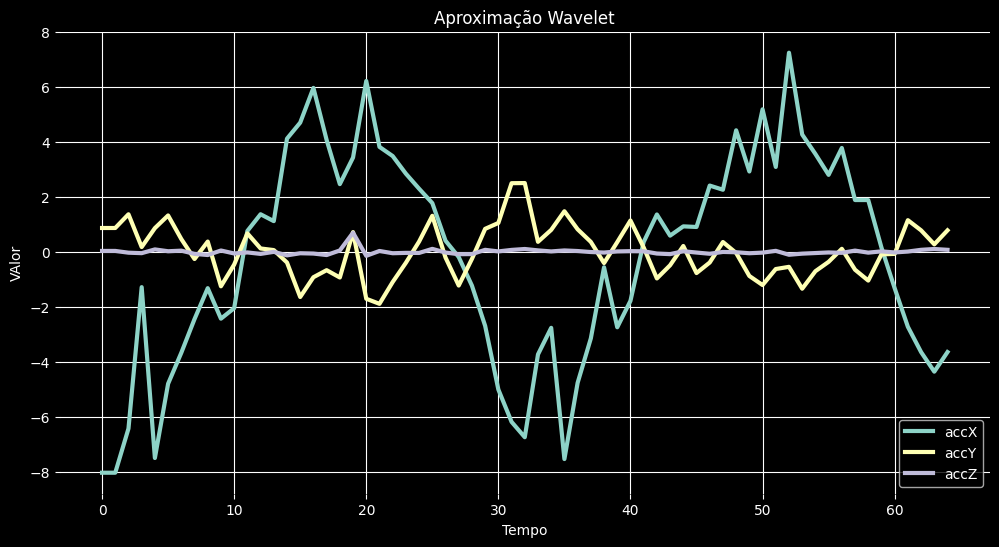

In [67]:
# Traçar o espectro de potência em relação à frequência 
# Como subtraímos a média no início, o compartimento 0 (DC) sempre será ~0, portanto, ignore-o
plt.plot(accX_l1, label='accX')
plt.plot(accY_l1, label='accY')
plt.plot(accZ_l1, label='accZ')
plt.legend(loc='lower right')
plt.xlabel('Tempo')
plt.ylabel('VAlor')
plt.title('Aproximação Wavelet')
plt.grid()
plt.box(False)
plt.show()

## Funções de extração de recursos

In [68]:
def calculate_statistics(signal):
    n5 = np.percentile(signal, 5)
    n25 = np.percentile(signal, 25)
    n75 = np.percentile(signal, 75)
    n95 = np.percentile(signal, 95)
    median = np.percentile(signal, 50)
    mean = np.mean(signal)
    std = np.std(signal)
    var = np.var(signal)
    rms = np.sqrt(np.mean(np.square(signal)))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

In [69]:
stat_feat_l0 = [calculate_statistics(x) for x in sensors]
stat_feat_l1 = [calculate_statistics(x) for x in sensors_l1]

In [73]:
print (f"feat_l0 ou l_1 tem {len(stat_feat_l0[0])} características estatísticas para cada um dos {len(stat_feat_l0)} eixos")

feat_l0 ou l_1 tem 9 características estatísticas para cada um dos 3 eixos


In [74]:
skew_l0 = [skew(x, bias=False) for x in sensors]
skew_l1 = [skew(x, bias=False) for x in sensors_l1]
kurtosis_l0 = [kurtosis(x, bias=False) for x in sensors]
kurtosis_l1 = [kurtosis(x, bias=False) for x in sensors_l1]

In [75]:
def getZeroCrossingRate(arr):
    my_array = np.array(arr)
    zcross = float("{0:.2f}".format((((my_array[:-1] * my_array[1:]) < 0).sum())/len(arr))) 
    return zcross

def getMeanCrossingRate(arr):
    mcross = getZeroCrossingRate(np.array(arr) - np.mean(arr))
    return mcross

In [76]:
def calculate_crossings(list):
    zcross=[]
    mcross=[]
    for i in range(len(list)):
        zcross_i = getZeroCrossingRate(list[i])
        zcross.append(zcross_i)
        mcross_i = getMeanCrossingRate(list[i])
        mcross.append(mcross_i)
    return zcross, mcross   

In [77]:
calculate_crossings(sensors_l1)

([0.06, 0.31, 0.4], [0.06, 0.31, 0.37])

In [78]:
cross_l0 = calculate_crossings(sensors)
cross_l1 = calculate_crossings(sensors_l1)

In [79]:
def calculate_entropy(signal, base=None):
    value, counts = np.unique(signal, return_counts=True)
    return entropy(counts, base=base)

In [80]:
entropy_l0 = [calculate_entropy(x) for x in sensors]
entropy_l1 = [calculate_entropy(x) for x in sensors_l1]

In [81]:
L1_features_names = ["L1-n5", "L1-n25", "L1-n75", "L1-n95", "L1-median", "L1-mean", "L1-std", "L1-var", "L1-rms", "L1-skew", "L1-Kurtosis", "L1-zcross", "L1-mcross", "L1-entropy"]
L0_features_names = ["L0-n5", "L0-n25", "L0-n75", "L0-n95", "L0-median", "L0-mean", "L0-std", "L0-var", "L0-rms", "L0-skew", "L0-Kurtosis", "L0-zcross", "L0-mcross", "L0-entropy"]

In [82]:
len(L1_features_names)

14

### Listar todos os recursos de weavelets e criar uma lista por camadas

In [83]:
all_feat_l0 = []
for i in range(len(axis)):
    feat_l0 = stat_feat_l0[i]+[skew_l0[i]]+[kurtosis_l0[i]]+[cross_l0[0][i]]+[cross_l0[1][i]]+[entropy_l0[i]]
    [print(axis[i]+' '+x+'= ', round(y, 4)) for x,y in zip(L0_features_names, feat_l0)][0]
    all_feat_l0.append(feat_l0)
all_feat_l0 = [item for sublist in all_feat_l0 for item in sublist]
print(f"\Todas características L0 = {len(all_feat_l0)}")

accX L0-n5=  -4.9364
accX L0-n25=  -1.8429
accX L0-n75=  1.8842
accX L0-n95=  3.8096
accX L0-median=  0.4058
accX L0-mean=  -0.0
accX L0-std=  2.7322
accX L0-var=  7.4651
accX L0-rms=  2.7322
accX L0-skew=  -0.099
accX L0-Kurtosis=  -0.3475
accX L0-zcross=  0.06
accX L0-mcross=  0.06
accX L0-entropy=  4.8283
accY L0-n5=  -1.149
accY L0-n25=  -0.4475
accY L0-n75=  0.4814
accY L0-n95=  1.1491
accY L0-median=  -0.0315
accY L0-mean=  0.0
accY L0-std=  0.7833
accY L0-var=  0.6136
accY L0-rms=  0.7833
accY L0-skew=  0.1756
accY L0-Kurtosis=  1.2673
accY L0-zcross=  0.29
accY L0-mcross=  0.29
accY L0-entropy=  4.8283
accZ L0-n5=  -0.1242
accZ L0-n25=  -0.0429
accZ L0-n75=  0.0349
accZ L0-n95=  0.0839
accZ L0-median=  -0.0112
accZ L0-mean=  0.0
accZ L0-std=  0.1383
accZ L0-var=  0.0191
accZ L0-rms=  0.1383
accZ L0-skew=  6.9463
accZ L0-Kurtosis=  68.1123
accZ L0-zcross=  0.35
accZ L0-mcross=  0.35
accZ L0-entropy=  4.5649
\Todas características L0 = 42


In [84]:
all_feat_l1 = []
for i in range(len(axis)):
    feat_l1 = stat_feat_l1[i]+[skew_l1[i]]+[kurtosis_l1[i]]+[cross_l1[0][i]]+[cross_l1[1][i]]+[entropy_l1[i]]
    [print(axis[i]+' '+x+'= ', round(y, 4)) for x,y in zip(L1_features_names, feat_l1)][0]
    all_feat_l1.append(feat_l1)
all_feat_l1 = [item for sublist in all_feat_l1 for item in sublist]
print(f"\Todas características L1 = {len(all_feat_l1)}")

accX L1-n5=  -7.3516
accX L1-n25=  -2.7641
accX L1-n75=  2.8462
accX L1-n95=  5.0924
accX L1-median=  0.4064
accX L1-mean=  -0.2133
accX L1-std=  3.8473
accX L1-var=  14.8015
accX L1-rms=  3.8532
accX L1-skew=  -0.2975
accX L1-Kurtosis=  -0.7631
accX L1-zcross=  0.06
accX L1-mcross=  0.06
accX L1-entropy=  4.1744
accY L1-n5=  -1.3234
accY L1-n25=  -0.6492
accY L1-n75=  0.7844
accY L1-n95=  1.361
accY L1-median=  0.0659
accY L1-mean=  0.0276
accY L1-std=  0.9345
accY L1-var=  0.8732
accY L1-rms=  0.9349
accY L1-skew=  0.2874
accY L1-Kurtosis=  0.0347
accY L1-zcross=  0.31
accY L1-mcross=  0.31
accY L1-entropy=  4.1317
accZ L1-n5=  -0.1126
accZ L1-n25=  -0.0493
accZ L1-n75=  0.0348
accZ L1-n95=  0.1022
accZ L1-median=  -0.0137
accZ L1-mean=  0.0025
accZ L1-std=  0.1053
accZ L1-var=  0.0111
accZ L1-rms=  0.1053
accZ L1-skew=  4.4095
accZ L1-Kurtosis=  28.6586
accZ L1-zcross=  0.4
accZ L1-mcross=  0.37
accZ L1-entropy=  4.1531
\Todas características L1 = 42


In [85]:
feat = all_feat_l0+all_feat_l1
len(feat)

84